In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i+1:s for i,s in enumerate(chars)}
itos[0]='.'
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3
X,Y = [],[]
for w in words:
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context),'--->',itos[ix])
        context = context[1:] +[ix]#crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
def build_dataset(words):
    block_size = 3
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context),'--->',itos[ix])
            context = context[1:] +[ix]#crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
len(words)


32033

In [115]:
X.shape,X.dtype,Y.shape,Y.dtype # 32,3 is context and y is the target

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [16]:
C = torch.randn((27,2)) #lets say each letter has 2 features 
#this is the embedding matrix initially

In [17]:
C[5]

tensor([1.2985, 1.6325])

In [22]:
F.one_hot(torch.tensor(5),num_classes=27).float()@C
# one_hot takes input only torch tensors
# we discard this method we will use indexing

tensor([1.2985, 1.6325])

In [23]:
C[torch.tensor([5,6,7,7,7,7])]

tensor([[ 1.2985,  1.6325],
        [ 0.6782, -1.1652],
        [ 1.6307, -0.0508],
        [ 1.6307, -0.0508],
        [ 1.6307, -0.0508],
        [ 1.6307, -0.0508]])

In [25]:
C[X].shape

torch.Size([32, 3, 2])

In [28]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [76]:
W1 = torch.randn((6,100))#6 inputs and 100 neurons
b1 = torch.randn(100)

In [70]:
# we need to do
# emb @ W1 + b1
#but before tht we need to convert [32,3,2] to [32,6]

#METHOD 1
# torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape
#METHOD 2
# torch.cat(torch.unbind(emb,1),1) #unbind gives 3 ....32,2 matrices as a tuple
#first two methods are inefficient and creates all kind of new memory
#METHOD 3
# but wait there is better 
# a = torch.arange(18)
# we can rerepresent this using view
# a.view(3,3,2)#as long as these numbers multiply to be the same this will work
#extremely efficient
# a.storage()
# emb.shape
# emb.view(32,6)==torch.cat(torch.unbind(emb,1),1)#True

In [77]:
h= torch.tanh(emb.view(-1,6)@W1 +b1)
#if you put -1 pytorch willl calculate itself what that -1 is according to the number of elements
h.shape

torch.Size([32, 100])

In [78]:
# broadcasting of b and W1
# 32, 100
#  1 ,100
# correct

In [86]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [90]:
logits = h@W2 + b2 #([32,27])
counts = logits.exp()
probs = counts/counts.sum(1,keepdims=True)
probs[0].sum()

tensor(1.0000)

In [95]:
loss = -probs[torch.arange(32),Y].log().mean()
loss

tensor(15.5170)

In [ ]:
# counts = logits.exp()
# probs = counts/counts.sum(1,keepdims=True)
# loss = -probs[torch.arange(32),Y].log().mean() 
# these three lines are useless pytorch has better thing
#F.cross_entropy is well behaved numerically , faster , and easy to back propagate through
# for example pytorch takes the maximum number in the tensor and minus it


In [ ]:
# =================== MAKING IT RESPECTABLE ======================#

In [236]:
Xtr.shape,Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [237]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,400),generator=g)#6 inputs and 100 neurons
b1 = torch.randn(400,generator=g)
W2 = torch.randn((400,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [238]:
sum(p.nelement() for p in parameters)

13681

In [239]:
for p in parameters:
    p.requires_grad=True

In [240]:
lre = torch.linspace(-3,0,1000)#1000 numbers between -3 and 0
lrs = 10**lre
# to determine the best learning rates

In [246]:
lri = []
lossi = []
stepi = [] #trying to keep track of steps
for i in range(10000):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
    
    #forward pass
    emb = C[Xtr[ix]]#(32,3,2)
    h= torch.tanh(emb.view(-1,6)@W1 +b1)#(32,100)
    logits = h@W2 + b2 #([32,27])
    loss = F.cross_entropy(logits,Ytr[ix])
#     print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

In [247]:
print(loss.item())

2.09234356880188


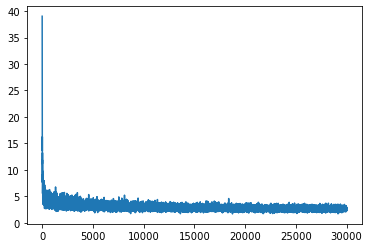

In [221]:
plt.plot(stepi,lossi)

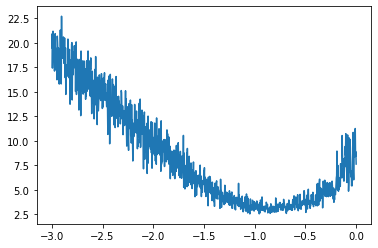

In [145]:
# plt.plot(lri,lossi)

In [248]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6)@W1+b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.2635, grad_fn=<NllLossBackward0>)

In [249]:
# tensor(2.3117, grad_fn=<NllLossBackward0>)training loss
# tensor(2.3166, grad_fn=<NllLossBackward0>) dev loss
# training loss and dev loss are about equal so underfitting (high bias)
# get a bigger network

In [250]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6)@W1+b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss


tensor(2.2752, grad_fn=<NllLossBackward0>)

In [ ]:
#training split , dev/validation split,test split
# 80% ,10%,10%

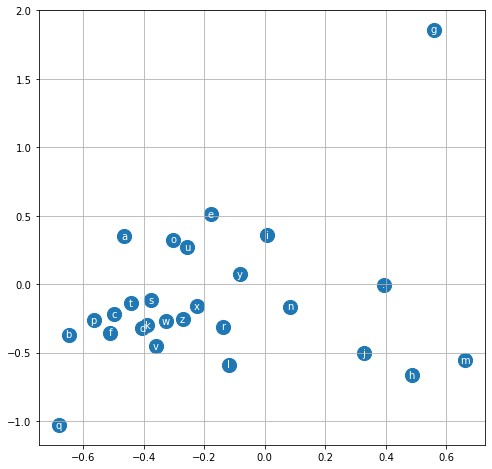

In [251]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va = "center",color='white')
plt.grid('minor')

In [252]:
# ============= INCREASING THE WORD EMBEDDINGS SIZE FROM 2 TO 10 ===============#

In [7]:
Xtr.shape,Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [63]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,400),generator=g)#6 inputs and 100 neurons
b1 = torch.randn(400,generator=g)
W2 = torch.randn((400,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [64]:
sum(p.nelement() for p in parameters)

23497

In [65]:
for p in parameters:
    p.requires_grad=True

In [66]:
lri = []
lossi = []
#trying to keep track of steps
stepi = []

In [69]:
for i in range(10000):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
    
    #forward pass
    emb = C[Xtr[ix]]#(32,3,2)
    h= torch.tanh(emb.view(-1,30)@W1 +b1)
    logits = h@W2 + b2 
    loss = F.cross_entropy(logits,Ytr[ix])
#     print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

In [70]:
print(loss.item())

1.845526099205017


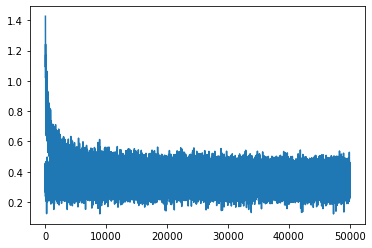

In [270]:
plt.plot(stepi,lossi)

In [73]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1930, grad_fn=<NllLossBackward0>)

In [74]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.2283, grad_fn=<NllLossBackward0>)

In [72]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amoril.
khi.
mili.
thay.
halaysie.
mahnel.
dellynn.
kaeli.
nellara.
chaiiy.
kaleigh.
ham.
join.
quinn.
shline.
kia.
bilia.
elo.
dearynix.


In [75]:
#============== INCREASING THE WORD EMBEDDING MATRIX SIZE FROM 10 TO 15=============#


In [76]:
Xtr.shape,Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [108]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,15),generator=g)
W1 = torch.randn((45,400),generator=g)#6 inputs and 100 neurons
b1 = torch.randn(400,generator=g)
W2 = torch.randn((400,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
sum(p.nelement() for p in parameters)

29632

In [109]:
lri = []
lossi = []
#trying to keep track of steps
stepi = []

In [118]:
for i in range(10000):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(64,))
    
    #forward pass
    emb = C[Xtr[ix]]#(32,3,2)
    h= torch.tanh(emb.view(-1,45)@W1 +b1)
    logits = h@W2 + b2 
    loss = F.cross_entropy(logits,Ytr[ix])
#     print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
#     lr = lrs[i]
    lr = 0.001
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

In [119]:
print(loss.item())

2.0846879482269287


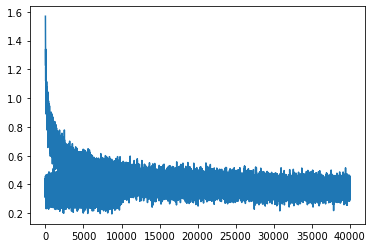

In [133]:
plt.plot(stepi,lossi)

In [120]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,45)@W1+b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1098, grad_fn=<NllLossBackward0>)

In [121]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,45)@W1+b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.2008, grad_fn=<NllLossBackward0>)

In [132]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khyrilli.
taty.
skahmane.
rah.
bradhviya.
jareei.
nellara.
chaily.
kaleigh.
ham.
poletebijona.
lilah.
jadiq.
watell.
dearyxi.
jacee.
dusci.
edde.


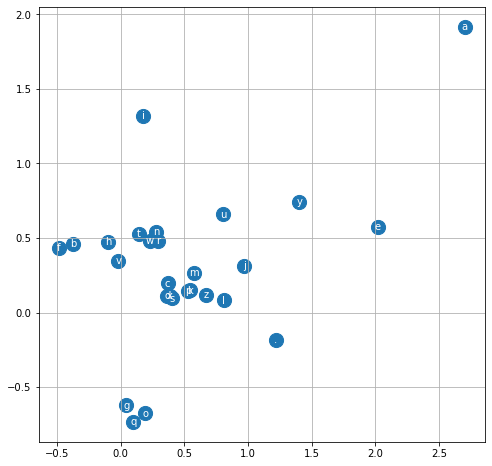

In [134]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va = "center",color='white')
plt.grid('minor')